In [1]:
import pandas as pd
file=r"C:\Users\OMEN\Documents\PYTORCH\IMAGE_CAPTIONING\data\captions.txt"

In [2]:
df=pd.read_csv(file)

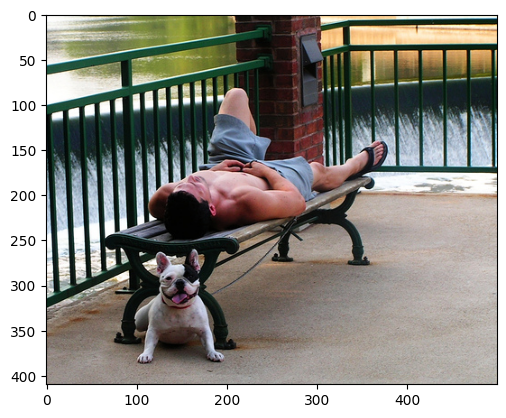

Caption: A man lays on the bench to which a white dog is also tied .
Caption: a man sleeping on a bench outside with a white and black dog sitting next to him .
Caption: A shirtless man lies on a park bench with his dog .
Caption: man laying on bench holding leash of dog sitting on ground


In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

data_idx=16
image_path=r"C:\Users\OMEN\Documents\PYTORCH\IMAGE_CAPTIONING\data"+ "/Images/"+df.iloc[data_idx,0]
img=mpimg.imread(image_path)
plt.imshow(img)
plt.show()

for i in range(data_idx,data_idx+4):
    print("Caption:",df.iloc[i,1])

In [4]:
!pip install spacy


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import os
from collections import Counter
import spacy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as transforms
from PIL import Image

In [6]:
spacy_eng = spacy.load("en_core_web_sm")

text="This is a good place "
[token.text.lower() for token in spacy_eng.tokenizer(text)]

['this', 'is', 'a', 'good', 'place']

In [7]:
class Vocabulary:
    def __init__(self,freq_threshold):
        self.itos = {0:"<PAD>",1:"<SOS>",2:"<EOS>",3:"<UNK>"}
        self.stoi = {v:k for k,v in self.itos.items()}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)
    
    @staticmethod
    def tokenize(text):
        return [token.text.lower() for token in spacy_eng.tokenizer(text)]
    

    def build_vocab(self, sentence_list):
        frequencies = Counter()
        idx = 4
        
        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                frequencies[word] += 1
                
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self,text):
        tokenized_text=self.tokenize(text)
        return [ self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in tokenized_text ]   

In [8]:
v = Vocabulary(freq_threshold=1)

v.build_vocab(["This is a good place to find a city"])
print(v.stoi)
print(v.numericalize("This is a good place to find a city over here"))

{'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'this': 4, 'is': 5, 'a': 6, 'good': 7, 'place': 8, 'to': 9, 'find': 10, 'city': 11}
[4, 5, 6, 7, 8, 9, 10, 6, 11, 3, 3]


In [9]:
class CaptionDataset(Dataset):

    def __init__(self,root_dir,file,transform=None,freq_threshold=4):
        self.root_dir = root_dir
        self.df = pd.read_csv(file)
        self.transform = transform

        self.imgs = self.df["image"]
        self.captions = self.df["caption"]

        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocab(self.captions.tolist())


    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        caption=self.captions[idx]
        img_name=self.imgs[idx]
        img_location=os.path.join(self.root_dir,img_name)
        img = Image.open(img_location).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        caption_vec = []
        caption_vec += [self.vocab.stoi["<SOS>"]]
        caption_vec += self.vocab.numericalize(caption)
        caption_vec += [self.vocab.stoi["<EOS>"]]
        
        return img, torch.tensor(caption_vec)

In [10]:
transforms=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [11]:
def show_image(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
        

Token: tensor([  1,   4,  30,  20,   4, 100,  50,  29, 712,  63,   8,   4, 269, 219,
          5,   2])
Sentence:
['<SOS>', 'a', 'child', 'and', 'a', 'woman', 'are', 'at', 'waters', 'edge', 'in', 'a', 'big', 'city', '.', '<EOS>']


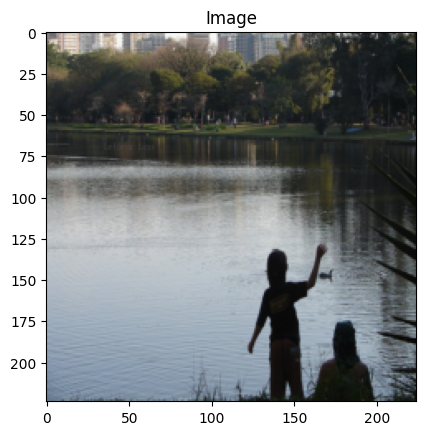

In [12]:
dataset =  CaptionDataset(
    root_dir = r"C:\Users\OMEN\Documents\PYTORCH\IMAGE_CAPTIONING\data"+"/Images",
    file = r"C:\Users\OMEN\Documents\PYTORCH\IMAGE_CAPTIONING\data"+"/captions.txt",
    transform=transforms
)


img, caps = dataset[80]
show_image(img,"Image")
print("Token:",caps)
print("Sentence:")
print([dataset.vocab.itos[token] for token in caps.tolist()])

In [13]:
class CapsCollate:
    def __init__(self, pad_idx, batch_first=False):
        self.pad_idx = pad_idx  # Index used to pad shorter captions
        self.batch_first = batch_first  # Whether to return shape (B, T) or (T, B)
    
    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]  # item[0] is image tensor
        imgs = torch.cat(imgs, dim=0)  # shape -> (batch_size, 3, H, W)

        targets = [item[1] for item in batch]  # item[1] is caption tensor (of variable length)
        targets = pad_sequence(
            targets, 
            batch_first=self.batch_first,  # True => (batch_size, seq_len)
            padding_value=self.pad_idx     # Use PAD token ID for padding
        )
        return imgs, targets


In [14]:
BATCH_SIZE = 4
NUM_WORKER = 1

pad_idx = dataset.vocab.stoi["<PAD>"]

data_loader = DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    collate_fn=CapsCollate(pad_idx=pad_idx,batch_first=True)
)

In [ ]:
#generating the iterator from the dataloader
# dataiter = iter(data_loader)

# #getting the next batch
# batch = next(dataiter)

# #unpacking the batch
# images, captions = batch

# #showing info of image in single batch
# for i in range(BATCH_SIZE):
#     img,cap = images[i],captions[i]
#     caption_label = [dataset.vocab.itos[token] for token in cap.tolist()]
#     eos_index = caption_label.index('<EOS>')
#     caption_label = caption_label[1:eos_index]
#     caption_label = ' '.join(caption_label)                      
#     show_image(img,caption_label)
#     plt.show()